In [3]:
#General Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import *
from time import *


from sklearn.preprocessing import OneHotEncoder


#To print out more decimal places and not in scientific notation

np.set_printoptions(precision=100,suppress=True)


#For LSTM

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense



In [4]:
#Load the training dataset

df_train = pd.read_excel('memrefs_train_andor_validate.xlsx', header = None)
df_train

,0
0,0xbfb22b18
1,0xbfb22b14
2,0xbfb22b10
3,0xbfb22b0c
4,0xbfb22b18
...,...
399995,0xbfb22978
399996,0xbfb22974
399997,0xbfb22980
399998,0xbfb22970


In [5]:
#Turn them into integers 

res = df_train[0].apply(int, base=16)
print(res)


0         3216124696
1         3216124692
2         3216124688
3         3216124684
4         3216124696
             ...    
399995    3216124280
399996    3216124276
399997    3216124288
399998    3216124272
399999    3216124268
Name: 0, Length: 400000, dtype: int64


In [6]:
#RAM was not enough (it needed 91 GB) when we were running the one-hot-encode so we had to trim the dataset down to 51000 values

dropping_len = 51000
res = res[:dropping_len]
res



0        3216124696
1        3216124692
2        3216124688
3        3216124684
4        3216124696
            ...    
50995    3216124288
50996    3216124264
50997     136511232
50998     136511276
50999    3216124288
Name: 0, Length: 51000, dtype: int64

In [7]:
training_data_len = ceil( len(res) *.8)
training_data_len

40800

In [8]:
testing_data_len = len(res) - training_data_len
testing_data_len

10200

In [9]:
training_set = np.array(res)
np.shape(training_set)

(51000,)

In [10]:
#Make a list that contains the differences between the previous and the current number (it has one less element than the training_set array)

diff = list()
for i in range(1, len(training_set)):
    value = training_set[i] - training_set[i - 1]
    diff.append(value)

In [11]:
diff =  pd.Series(diff) 
diff

0                -4
1                -4
2                -4
3                12
4                -4
            ...    
50994            24
50995           -24
50996   -3079613032
50997            44
50998    3079613012
Length: 50999, dtype: int64

In [12]:
np.shape(diff)

(50999,)

In [13]:
#Display which ones are the most frequent difference values we have

values_count = diff.value_counts()
values_count.head(50)

 4             7802
-4             7340
 0             4706
-8             1619
 12            1026
-12             972
 72             920
 88             892
 16             846
 8              694
 20             680
-32             616
-80             476
 84             452
-152            449
 3079614696     445
-3079682104     444
 3079682100     444
-3079614864     444
-3079682028     437
-161745640      437
 163196680      437
-1451040        437
 3079682024     437
-163196684      437
 28             436
 1              412
 24             361
-16             288
 40             222
 32             177
-28             157
-24             152
 1263439        142
 44             140
-20             135
-36             127
-124            121
 124            117
 36             113
 78              87
 60              84
-40              80
-56              78
-76              77
 1263313         76
-1700            68
 48              68
 1263471         66
 1544            60


In [14]:
diff = np.array(diff)

In [15]:
#Reshape in into a column

diff = diff.reshape(-1,1)

In [16]:
np.shape(diff)

(50999, 1)

In [17]:
#Append batches of 999 values on X_train and the 1000th value on y_train, then shifting the 'sliding window' one position to the right and so on

X_train = []
y_train = []
for i in range(999, len(diff)):
    X_train.append(diff[i-999: i])
    y_train.append(diff[i])

In [18]:
np.shape(X_train)

(50000, 999, 1)

In [19]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [20]:
#Reshape it in order to put it in the LSTM in the form of (number of batches, timesteps, number of features)

X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))

In [21]:
np.shape(X_train)

(50000, 999, 1)

In [22]:
y_train = y_train.reshape(-1,1)

In [23]:
#One-hot encode the values of y_train so they can be used in the LSTM (We get 5958 classes)

encoder = OneHotEncoder(drop='first', sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_onehot = encoder.fit_transform(y_train)
np.shape(y_onehot)

(50000, 5958)

In [24]:
#We have 2 hidden layers, 128 neurons in each hidden layer, a dropout of 20% and softmax as our activation function

model = keras.Sequential() 
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), dropout = 0.2 ))
model.add(LSTM(128, return_sequences=False, dropout = 0.2  ))
model.add(Dense(5958, activation = 'softmax'))

In [25]:
start = time()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy']) 
print ('compilation time : ', time() - start)

compilation time :  0.023860931396484375


In [26]:
history = model.fit(X_train, y_onehot, epochs=64, batch_size=100, verbose=1, validation_split=0.2, shuffle = False )  

Epoch 1/64
400/400 [==============================] - 158s 396ms/step - loss: 4.8034 - accuracy: 0.1733 - val_loss: 5.7637 - val_accuracy: 0.1735
Epoch 2/64
400/400 [==============================] - 157s 392ms/step - loss: 3.8964 - accuracy: 0.3505 - val_loss: 5.8487 - val_accuracy: 0.1504
Epoch 3/64
400/400 [==============================] - 158s 394ms/step - loss: 3.5249 - accuracy: 0.4362 - val_loss: 5.8609 - val_accuracy: 0.1713
Epoch 4/64
400/400 [==============================] - 157s 393ms/step - loss: 3.2497 - accuracy: 0.4967 - val_loss: 5.8529 - val_accuracy: 0.1562
Epoch 5/64
400/400 [==============================] - 157s 392ms/step - loss: 3.0269 - accuracy: 0.5294 - val_loss: 5.6316 - val_accuracy: 0.1599
Epoch 6/64
400/400 [==============================] - 155s 389ms/step - loss: 2.8651 - accuracy: 0.5479 - val_loss: 5.4978 - val_accuracy: 0.1645
Epoch 7/64
400/400 [==============================] - 157s 393ms/step - loss: 2.7207 - accuracy: 0.5579 - val_loss: 5.1757 -

In [27]:
test_data = diff[training_data_len:]
test_data

array([[          8],
       [          4],
       [          4],
       ...,
       [-3079613032],
       [         44],
       [ 3079613012]])

In [28]:
#We repeat the same process of appending the values for the test portion of our data (the last 20% of the dataset)

x_test = []
y_test = [] 
for i in range(999,len(test_data)):
    x_test.append(test_data[i-999:i])
    y_test.append(test_data[i])

In [29]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [30]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [31]:
predictions = model.predict(x_test) 

In [32]:
#The predictions come out one-hot-encoded

predictions

array([[0.000000000000009595148         ,
        0.000000000000000008480671      ,
        0.0000000000000004934298        , ...,
        0.00000000000023799382          ,
        0.0000000000008887756           ,
        0.0000000000002519562           ],
       [0.000000000000012558829         ,
        0.00000000000000027126397       ,
        0.0000000000000012357279        , ...,
        0.00000000000000758675          ,
        0.000000000000017485765         ,
        0.0000000000000021461621        ],
       [0.00000000000000000005744997    ,
        0.000000000000000000000008929699,
        0.0000000000000000011120215     , ...,
        0.0000000000000000028847272     ,
        0.00000000000000008133032       ,
        0.00000000000000027086512       ],
       ...,
       [0.0000000000000000007431059     ,
        0.000000000000000000021466318   ,
        0.000000000000000024557836      , ...,
        0.00000000000000033263865       ,
        0.00000000000000003007489       ,

In [33]:
np.shape(predictions)

(9200, 5958)

In [34]:
np.shape(y_test)

(9200, 1)

In [35]:
np.shape(res)

(51000,)

In [36]:
#We reverse the differences, getting the real values of y_test in order to compare them to our predictions

for i in range(0,len(y_test)-1):
  y_test[i] =  res[training_data_len + 999 + i+1] - y_test[i]

In [37]:
y_test

array([[3216123932],
       [3216124044],
       [3216123964],
       ...,
       [3216124264],
       [ 136511232],
       [3079613012]])

In [38]:
y_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
#We undo the one-hot encoding taking the maximum of each row and keeping the column number where that maximum is found, and then from this number finding the column label

maximums = []
for i in range(0,predictions.shape[0]):
  max = 0
  column = 0
  temp = 0
  for j in range(0,predictions.shape[1]):
    temp = predictions[i][j]
    if temp > max: 
      max = temp
      column = j
  maximums.append(encoder.get_feature_names()[column]) 

In [40]:
maximums

['x0_112',
 'x0_-80',
 'x0_80',
 'x0_-76',
 'x0_80',
 'x0_-76',
 'x0_44',
 'x0_0',
 'x0_-72',
 'x0_4',
 'x0_4',
 'x0_4',
 'x0_44',
 'x0_32',
 'x0_-4',
 'x0_-8',
 'x0_-12',
 'x0_0',
 'x0_32',
 'x0_-4',
 'x0_-12',
 'x0_144',
 'x0_-192',
 'x0_4',
 'x0_4',
 'x0_4',
 'x0_4',
 'x0_212',
 'x0_-208',
 'x0_8',
 'x0_196',
 'x0_-200',
 'x0_-8',
 'x0_-4',
 'x0_-4',
 'x0_-4',
 'x0_-4',
 'x0_-4',
 'x0_0',
 'x0_0',
 'x0_24',
 'x0_-161745040',
 'x0_161743636',
 'x0_1494',
 'x0_-161745338',
 'x0_161745372',
 'x0_-124',
 'x0_124',
 'x0_-124',
 'x0_20',
 'x0_-16',
 'x0_-4',
 'x0_90',
 'x0_-161745338',
 'x0_161745372',
 'x0_-124',
 'x0_124',
 'x0_-124',
 'x0_20',
 'x0_-12',
 'x0_-1512',
 'x0_1456',
 'x0_4',
 'x0_20',
 'x0_-1512',
 'x0_1540',
 'x0_-1544',
 'x0_-4',
 'x0_-4',
 'x0_-12',
 'x0_-16',
 'x0_0',
 'x0_0',
 'x0_20',
 'x0_16',
 'x0_-12',
 'x0_16',
 'x0_-3079808679',
 'x0_3079808655',
 'x0_4',
 'x0_4',
 'x0_4',
 'x0_4',
 'x0_1544',
 'x0_-1396',
 'x0_1416',
 'x0_-1436',
 'x0_1416',
 'x0_0',
 'x0_-1416

In [41]:
#We turn the values into integers

for i in range(0,predictions.shape[0]):
  maximums[i] = maximums[i].replace('x0_', '')
  maximums[i] = int(maximums[i])

In [42]:
maximums = np.array(maximums)
maximums

array([        112,         -80,          80, ..., -3079613032,
                20,  3079612996])

In [43]:
for i in range(0,len(maximums)-1):
  maximums[i] =  res[training_data_len + 999 + i+1] - maximums[i]

In [44]:
maximums

array([3216123932, 3216124044, 3216123964, ..., 3216124264,  136511256,
       3079612996])

In [46]:
#Count is the number of correct guesses we got for our testing dataset 


count =0
for i in range(0,len(y_test)):
  if y_test[i] == maximums[i]:
    count = count + 1
print(count/(len(y_test))*100)

#The number below is the hit rate

78.11956521739131


In [47]:
print(history.history['loss'])
print(history.history['val_loss'])


[4.8033857345581055, 3.8964221477508545, 3.524921178817749, 3.2497270107269287, 3.026869058609009, 2.8650882244110107, 2.7207229137420654, 2.5971081256866455, 2.5073962211608887, 2.4179069995880127, 2.3328099250793457, 2.2478115558624268, 2.158125877380371, 2.080136299133301, 1.9983150959014893, 1.9258400201797485, 1.8552519083023071, 1.7899212837219238, 1.7249348163604736, 1.6727482080459595, 1.6227577924728394, 1.5712958574295044, 1.5151417255401611, 1.4637432098388672, 1.4130451679229736, 1.375810980796814, 1.3302631378173828, 1.30161714553833, 1.2684406042099, 1.2315980195999146, 1.2175817489624023, 1.1781713962554932, 1.1693782806396484, 1.1435405015945435, 1.1166502237319946, 1.0917969942092896, 1.0860567092895508, 1.0808987617492676, 1.0672212839126587, 1.0495100021362305, 1.0350143909454346, 1.0153440237045288, 1.0028703212738037, 0.9925784468650818, 0.976266086101532, 0.9605761766433716, 0.9566385746002197, 0.9496559500694275, 0.9340852499008179, 0.9395700097084045, 0.92859852

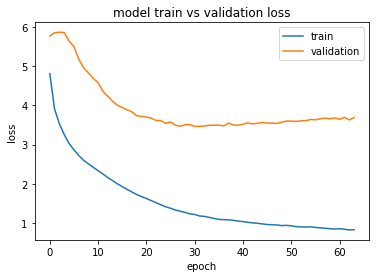

In [80]:
#Loss is not really the metric we are interested in testing when it comes to classification

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation','accuracy'], loc='upper right')
plt.show()

In [83]:
print(history.history['accuracy'])

[0.17329999804496765, 0.3504999876022339, 0.4361500144004822, 0.49665001034736633, 0.529449999332428, 0.5479000210762024, 0.5579249858856201, 0.5655999779701233, 0.5706250071525574, 0.5773500204086304, 0.5824249982833862, 0.5922750234603882, 0.6011250019073486, 0.6063500046730042, 0.6151000261306763, 0.6242499947547913, 0.6337500214576721, 0.641700029373169, 0.6501749753952026, 0.6592749953269958, 0.6655750274658203, 0.672124981880188, 0.6813499927520752, 0.6879749894142151, 0.6948249936103821, 0.6998500227928162, 0.7075499892234802, 0.713949978351593, 0.7182750105857849, 0.723924994468689, 0.7258750200271606, 0.7318249940872192, 0.734000027179718, 0.7368249893188477, 0.7408750057220459, 0.7473499774932861, 0.7459499835968018, 0.7452999949455261, 0.7490749955177307, 0.75204998254776, 0.7546250224113464, 0.7572500109672546, 0.7596750259399414, 0.7601500153541565, 0.764074981212616, 0.7669000029563904, 0.7651500105857849, 0.7692750096321106, 0.7712000012397766, 0.7703499794006348, 0.7721

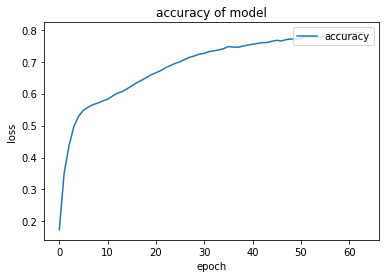

In [81]:
#Accuracy is the metric we are aiming for
plt.plot(history.history['accuracy'])
plt.title('accuracy of model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['accuracy'], loc='upper right')
plt.show()

In [82]:
#Again, rmse is a bit irrelevant when it comes to classification

rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

2771347451.8008304

In [50]:
#We load the dataset to predict the values of the empty cells and we follow a similar procedure

df_test = pd.read_excel('memrefs_testing_Sept.xlsx', header = None)
df_test

,0
0,0xbfb229b4
1,0xbfb229b8
2,0xbfb229bc
3,0xbfb22a74
4,0x8249704
...,...
49945,0xbfb22998
49946,0xbfb22994
49947,0xbfb22990
49948,0xbfb229a0


In [51]:
test_res = df_test[0].apply(int, base=16)
print(test_res)

0        3216124340
1        3216124344
2        3216124348
3        3216124532
4         136615684
            ...    
49945    3216124312
49946    3216124308
49947    3216124304
49948    3216124320
49949     136509456
Name: 0, Length: 49950, dtype: int64


In [52]:
test_array = np.array(test_res)
test_array

array([3216124340, 3216124344, 3216124348, ..., 3216124304, 3216124320,
        136509456])

In [53]:
#Differences

test_diff = list()
for i in range(1, len(test_array)):
    value = test_array[i] - test_array[i - 1]
    test_diff.append(value)

In [54]:
#We add the -4 as one of the values of the differences that most commonly occurs, because the last value of the difference dataset does not exist (it doesn't have a next value to be subtracted from)

test_diff.append(-4)

In [55]:
test_diff =  pd.Series(test_diff) 

In [56]:
test_values_count = test_diff.value_counts()
test_values_count.head(50)

 4             7668
-4             6793
 0             4298
-8             1718
 12             859
-12             810
 88             717
 20             707
 72             701
 16             690
 8              666
-32             557
 24             544
 28             436
 1              421
-80             370
 84             359
-152            332
-3079682104     321
-3079614864     321
 3079614696     320
 3079682100     320
-3079682028     296
 3079682024     296
 163196680      296
-1451040        296
-161745640      296
-163196684      295
-28             294
-16             259
 32             254
-36             234
-20             205
 40             191
 36             155
-24             154
 52             152
-3079681768     151
 44             141
-40             126
 124            125
-3079613088     120
-3079613072     100
 64              99
 392             98
-3079612984      98
-48              94
-52              94
-3079681784      92
-76              91


In [57]:
test_diff = np.array(test_diff)

In [58]:
test_diff

array([          4,           4,         184, ...,          16,
       -3079614864,          -4])

In [59]:
test_diff = test_diff.reshape(-1,1)

In [60]:
np.shape(test_diff)

(49950, 1)

In [61]:
#We create the dataset that we will use for the prediction by keeping the first 999 values and then predicting the 1000th, then keeping the next 1000 values (1001-1999 in the excel doc) and predicting the 2000th value and so on

test_predictions = []
for i in range(0,len(test_diff),999):
    test_predictions.append(test_diff[i:(i+999)])

In [63]:
len(test_diff)

49950

In [64]:
np.shape(test_predictions)

(50, 999, 1)

In [65]:
test_predictions = np.array(test_predictions)

In [66]:
test_predictions = np.reshape(test_predictions, newshape = (test_predictions.shape[0],test_predictions.shape[1],1))


In [67]:
np.shape(test_predictions)

(50, 999, 1)

In [68]:
results = model.predict(test_predictions) 

In [69]:
np.shape(results)

(50, 5958)

In [70]:
#The results are one-hot encoded

results

array([[0.00000000000003403161     , 0.000000000000008866591    ,
        0.00000000000001130396     , ..., 0.0000000000000073043175   ,
        0.000000000000031382615    , 0.000000000000013524553    ],
       [0.0000000005019307         , 0.0000000011354717         ,
        0.0000000015096766         , ..., 0.00000000000008516058     ,
        0.000000000000073285       , 0.000000000000033888043    ],
       [0.0000000000014095734      , 0.0000000000000061490547   ,
        0.000000000007802483       , ..., 0.0000000000024193657      ,
        0.0000000000034601256      , 0.0000000000026019102      ],
       ...,
       [0.000000000007372208       , 0.000000000000005768751    ,
        0.0000000000066406876      , ..., 0.000000000000027531146    ,
        0.0000000000002389313      , 0.000000000000058493805    ],
       [0.000000000000005696033    , 0.00000000000000040411095  ,
        0.0000000000000018383014   , ..., 0.00000000000033999114     ,
        0.0000000000003769048      

In [71]:
#Code to decode the one-hot encoding (the same explanation as above)

test_maximums = []
for i in range(0,results.shape[0]):
  max = 0
  column = 0
  temp = 0
  for j in range(0,results.shape[1]):
    temp = results[i][j]
    if temp > max: 
      max = temp
      column = j
  test_maximums.append(encoder.get_feature_names()[column]) 

In [72]:
np.shape(test_maximums)

(50,)

In [73]:
test_maximums

['x0_4',
 'x0_-4',
 'x0_-4',
 'x0_-4',
 'x0_-28',
 'x0_-88',
 'x0_-4',
 'x0_12',
 'x0_4',
 'x0_3079608476',
 'x0_-12',
 'x0_88',
 'x0_-4',
 'x0_-4',
 'x0_-4',
 'x0_4',
 'x0_4',
 'x0_-4',
 'x0_-4',
 'x0_-4',
 'x0_-4',
 'x0_-4',
 'x0_-161745040',
 'x0_12',
 'x0_4',
 'x0_192',
 'x0_-59731',
 'x0_-4',
 'x0_12',
 'x0_0',
 'x0_4',
 'x0_84',
 'x0_4',
 'x0_0',
 'x0_4',
 'x0_-4',
 'x0_4',
 'x0_4',
 'x0_-4',
 'x0_12',
 'x0_0',
 'x0_4',
 'x0_-16',
 'x0_-4',
 'x0_-129970240',
 'x0_-3079608560',
 'x0_4',
 'x0_32',
 'x0_1263439',
 'x0_88']

In [74]:
for i in range(0,results.shape[0]):
  test_maximums[i] = test_maximums[i].replace('x0_', '')
  test_maximums[i] = int(test_maximums[i])

In [75]:
test_maximums = np.array(test_maximums)
test_maximums

array([          4,          -4,          -4,          -4,         -28,
               -88,          -4,          12,           4,  3079608476,
               -12,          88,          -4,          -4,          -4,
                 4,           4,          -4,          -4,          -4,
                -4,          -4,  -161745040,          12,           4,
               192,      -59731,          -4,          12,           0,
                 4,          84,           4,           0,           4,
                -4,           4,           4,          -4,          12,
                 0,           4,         -16,          -4,  -129970240,
       -3079608560,           4,          32,     1263439,          88])

In [76]:
#Code to reverse the differences

for i in range(0,len(test_maximums)-1):
  if i == 0:
    test_maximums[0] = test_res[1000] - test_maximums[0]
  else:
    test_maximums[i] =  test_res[i * 999 +1] - test_maximums[i]
  

In [77]:
#The last value is a bit random because the difference was chosen as -4 (we couldn't find a way to predict the last number because the difference was not known)

test_maximums

array([3216124324, 3216124332,  136547928,  136442128,  136616937,
       3216124056, 3216122228, 3216124332, 3216124312,  136515552,
       3216124292, 3216123348,  136509616, 3216124324, 3216124244,
       3216124300,  136509460, 3216124196, 3216124352,  136509616,
       3216124276, 3216124204, 3377869336, 3216123976, 3216124528,
       3216124124, 3216184075,  136510006, 3216123976, 3216124244,
       3216124020, 3216124200,  136509608, 3216124268, 3216124308,
       3216124024,  136442448, 3216124324, 3216124188, 3216123960,
       3216122264, 3216123940, 3216122268, 3216124336, 3346094560,
       6295732596,  136623460, 3216123472, 3214860597,         88])

In [78]:
#Code to turn it into hex from int

end_results = []
for i in range(0,len(test_maximums)):
  end_array = hex(test_maximums[i])
  end_results.append(end_array)

end_results

['0xbfb229a4',
 '0xbfb229ac',
 '0x8238e58',
 '0x821f110',
 '0x8249be9',
 '0xbfb22898',
 '0xbfb22174',
 '0xbfb229ac',
 '0xbfb22998',
 '0x8230fe0',
 '0xbfb22984',
 '0xbfb225d4',
 '0x822f8b0',
 '0xbfb229a4',
 '0xbfb22954',
 '0xbfb2298c',
 '0x822f814',
 '0xbfb22924',
 '0xbfb229c0',
 '0x822f8b0',
 '0xbfb22974',
 '0xbfb2292c',
 '0xc9563218',
 '0xbfb22848',
 '0xbfb22a70',
 '0xbfb228dc',
 '0xbfb3130b',
 '0x822fa36',
 '0xbfb22848',
 '0xbfb22954',
 '0xbfb22874',
 '0xbfb22928',
 '0x822f8a8',
 '0xbfb2296c',
 '0xbfb22994',
 '0xbfb22878',
 '0x821f250',
 '0xbfb229a4',
 '0xbfb2291c',
 '0xbfb22838',
 '0xbfb22198',
 '0xbfb22824',
 '0xbfb2219c',
 '0xbfb229b0',
 '0xc77159e0',
 '0x177414174',
 '0x824b564',
 '0xbfb22650',
 '0xbf9ee135',
 '0x58']